In [1]:
import os
import pandas as pd
import numpy as np
from math import sqrt
from os.path import join
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
# define root mean squared error
def rmse(y_actual, y_predicted):
    return round(sqrt(mean_squared_error(y_actual, y_predicted)), 2)

In [3]:
os.chdir(r"C:\Users\arsha\Projects\Kaggle\House_Prices")
train_file_name = "data\\train.csv"
dfTrainData = pd.read_csv(train_file_name)
target = dfTrainData.iloc[:, -1]
dfData = dfTrainData.iloc[:, :len(dfTrainData.columns) - 1]

In [4]:
# Some feature engineering
dfData['age_at_sale'] = dfData.YrSold - dfData.YearBuilt
dfData['age_at_remodel'] = dfData.YrSold - dfData.YearRemodAdd
dfData['age_at_remodel'] = dfData['age_at_remodel'].apply(lambda x: 0 if x < 0 else x)

In [5]:
list_of_object_columns = []
list_of_numeric_columns = []

# separating object column types with others
for column in dfData.columns:
    if dfData[column].dtype == object:
        list_of_object_columns.append(column)
    else:
        list_of_numeric_columns.append(column)

In [6]:
# first processing only numberic columns
dfNumerics = dfData[list_of_numeric_columns].copy()

In [7]:
dfNumerics.drop(["Id"], inplace=True, axis=1)

In [8]:
# find columns with missing values
list_of_columns_with_missing_values = []
list_of_complete_columns = []
dict_medians = {}

for column in dfNumerics.columns:
    dict_medians[column] = dfNumerics[column].median()
    bln = dfNumerics[column].isnull().values.any()
    if bln:
        list_of_columns_with_missing_values.append(column)
    else:
        list_of_complete_columns.append(column)

In [9]:
# impute missing values by the median value of the column
for column in list_of_columns_with_missing_values:
#     dfNumerics[column] = dfNumerics[column].fillna(dfNumerics[column].median())
    dfNumerics[column] = dfNumerics[column].fillna(dict_medians[column])

In [10]:
# here we will work only with object column types
dfCategorical = dfData.select_dtypes(include=['object']).copy()

In [11]:
# drop categorical columns that have too many of the same value, 95% or more
list_cat_columns_to_drop = []
ttl_number_of_rows = dfCategorical.shape[0]

for column in dfCategorical.columns:
    d = dfCategorical[column].value_counts()
    number_of_categories = d.shape[0]
    
    # checking the number of missing values
    number_missing_values = dfCategorical[column].isnull().sum()
    if number_missing_values / ttl_number_of_rows > 0.9:
        list_cat_columns_to_drop.append(column)
        continue
    
    # if there is only one category in the column, we do not really need it
    if number_of_categories < 2:
        list_cat_columns_to_drop.append(column)
        continue
        
    # checking if one of the categories has more than 95 of rows
    for i in range(number_of_categories):
        if d[i] / ttl_number_of_rows > 0.95:
            list_cat_columns_to_drop.append(column)
            break
            
list_cat_columns_to_keep = [c for c in list(dfCategorical.columns) if c not in list_cat_columns_to_drop]   

In [12]:
# drop columns with too many missing values or with only unique values
dfCategorical.drop(list_cat_columns_to_drop, axis=1, inplace=True)

In [13]:
# converting categorical columns into numeric and renaming column names by adding _cat at the end of the column name
old_categorical_column_names = dfCategorical.columns
for column in dfCategorical.columns:
    dfCategorical[column] = dfCategorical[column].astype('category')
    new_column_name = column + "_cat"
    dfCategorical[new_column_name] = dfCategorical[column].cat.codes
    
# adding one to get rid of -1's that are assigned to NA values
dfCategoricalNew = dfCategorical.drop(old_categorical_column_names, axis = 1).copy()
dfCategoricalNew = dfCategoricalNew + 1

In [14]:
# combining numberic and categorical columns
X = pd.concat([dfNumerics, dfCategoricalNew], axis=1)

In [15]:
COLUMN_MASTER_LIST_TO_KEEP = X.columns

In [16]:
# creating interactions for numeric variables
from sklearn.preprocessing import PolynomialFeatures
pf = PolynomialFeatures(2, interaction_only=True, include_bias=False)

number_ndarray_with_interactions = pf.fit_transform(X)
column_names_with_interactions = list(pf.get_feature_names(X.columns))

dfAllInteractions = pd.DataFrame(number_ndarray_with_interactions)
dfAllInteractions.columns = column_names_with_interactions

In [17]:
# creating training and test sets
X_train, X_test, y_train, y_test = train_test_split(dfAllInteractions, target, test_size=0.2, random_state=191)

## Random Forest Regressor

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [21]:
rf_regr = RandomForestRegressor(n_estimators=25)

In [22]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'n_jobs': [-1]
}

In [23]:
grid_search = GridSearchCV(rf_regr, param_grid=param_grid, return_train_score=True)

In [24]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50, 100, 150], 'max_depth': [5, 10, 15], 'n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [25]:
# grid_search.cv_results_ (24355.24)
rmse(y_test, grid_search.predict(X_test))

24435.36

## Support Vector Regressor

In [31]:
from sklearn.svm import SVR
sv_regr = SVR()
sv_regr.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [32]:
rmse(y_test, sv_regr.predict(X_test))

78222.41

## XGBOOST

In [19]:
from xgboost import XGBRegressor

In [20]:
xgb_regr = XGBRegressor()

In [84]:
param_test = {
    'max_depth': range(5,8,2),
    'min_child_weight':range(3,6,2)
}

In [85]:
gridSearch1 = GridSearchCV(estimator=XGBRegressor(learning_rate =0.1, n_estimators=125, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.9, colsample_bytree=0.8, nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)

In [86]:
gridSearch1.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=125,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.9),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': range(5, 8, 2), 'min_child_weight': range(3, 6, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [88]:
rmse(y_test, gridSearch1.predict(X_test))

21272.21

# Scoring the test dataset

In [44]:
# scoring the test dataset
test_filename = 'data\\test.csv'
dfTest = pd.read_csv(open(test_filename))

dfTest['age_at_sale'] = dfTest.YrSold - dfTest.YearBuilt
dfTest['age_at_remodel'] = dfTest.YrSold - dfTest.YearRemodAdd
dfTest['age_at_remodel'] = dfTest['age_at_remodel'].apply(lambda x: 0 if x < 0 else x)

In [45]:
# list_of_object_columns
dfTestNumeric = dfTest[list_of_numeric_columns]

In [46]:
dfTestNumeric.drop(["Id"], inplace=True, axis=1)

C:\Users\arsha\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [47]:
for column in dict_medians.keys():
    if dfTestNumeric[column].isnull().values.any():
        dfTestNumeric[column] = dfTestNumeric[column].fillna(dict_medians[column])

C:\Users\arsha\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [48]:
dfTestCat = dfTest[list_cat_columns_to_keep]

In [49]:
# converting categorical columns into numeric and renaming column names by adding _cat at the end of the column name
old_categorical_column_names = dfTestCat.columns
for column in dfTestCat.columns:
    dfTestCat[column] = dfTestCat[column].astype('category')
    new_column_name = column + "_cat"
    dfTestCat[new_column_name] = dfTestCat[column].cat.codes


C:\Users\arsha\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\arsha\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [50]:
# adding one to get rid of -1's that are assigned to NA values
dfTestCatNew = dfTestCat.drop(old_categorical_column_names, axis = 1).copy()
dfTestCatNew = dfTestCatNew + 1

In [51]:
Xtest = pd.concat([dfTestNumeric, dfTestCatNew], axis=1)

In [52]:
dfForScore = Xtest[COLUMN_MASTER_LIST_TO_KEEP].copy()

In [53]:
# creating interactions for numeric variables
from sklearn.preprocessing import PolynomialFeatures
pf = PolynomialFeatures(2, interaction_only=True, include_bias=False)

In [54]:
number_ndarray_with_interactions = pf.fit_transform(dfForScore)
column_names_with_interactions = list(pf.get_feature_names(Xtest.columns))

In [55]:
dfForScoreAll = pd.DataFrame(number_ndarray_with_interactions)
dfForScoreAll.columns = column_names_with_interactions

In [40]:
LIST_OF_SCORE_COLUMNS = list(dfForScoreAll.columns)

In [43]:
f = open("test_columns.csv", "w")
for idx, column in enumerate(list(dfForScoreAll.columns)):
    s = str(idx) + "," + list(dfForScoreAll.columns)[idx] + "," + list(dfAllInteractions.columns)[idx] + "\n"
    f.write(s)
f.close()

In [96]:
predicted_prices = gridSearch1.predict(dfForScoreAll)

In [97]:
dfPredictedPrices = pd.DataFrame(predicted_prices)
dfPredictedPrices.columns = ['PredictedPrice']

In [98]:
dfFinal = pd.concat([dfTest, dfPredictedPrices], axis=1)

In [99]:
dfFinal.to_csv("data\\predicted_prices1.csv", index=False)

In [86]:
dfYTestActual = y_test.to_frame()

dfYTestPredicted = pd.DataFrame(xgb_regr.predict(X_test))
dfYTestPredicted.columns = ['predicted']
dfYTestActual.columns = ['actual']
dfYTestPredicted['predicted'] = dfYTestPredicted['predicted'].apply(lambda x: round(x, 0))

In [87]:
list_actual_y = list(y_test)
list_predicted_y = list(xgb_regr.predict(X_test))

In [88]:
dfY_actual = pd.Series(list_actual_y).to_frame()
dfY_pred = pd.Series(list_predicted_y).to_frame()

In [89]:
dfY = pd.concat([dfY_actual, dfY_pred], axis=1)
dfY.columns = ['actual', 'predicted']
dfY['predicted'] = dfY['predicted'].apply(lambda x: round(x, 1))
dfY['diff'] = dfY['predicted'] - dfY['actual']

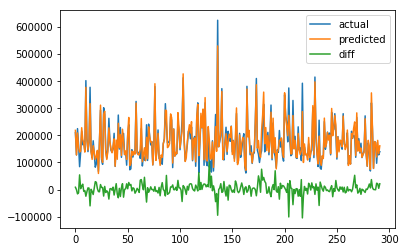

In [90]:
dfY.plot(kind="line")
plt.show()